## Scale Free Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import powerlaw
import seaborn as sns
from operator import itemgetter
from collections import Counter
# import graph_tool.all as gt

In [ ]:
# load network
# g = gt.collection.ns["eu_airlines"]
G = nx.read_graphml('/content/drive/MyDrive/Colab Notebooks/network.xml')

# Sublayers of airlines

## Divide flights into 37 sublayers of airlines

In [ ]:
# layer key for airlines
layer_key  = {1: 'Lufthansa', 2: 'Ryanair', 3: 'Easyjet', 4: 'British_Airways', 5: 'Turkish_Airlines', 6: 'Air_Berlin', 7: 'Air_France', 8: 'Scandinavian_Airlines', 9: 'KLM', 10: 'Alitalia', 11: 'Swiss_International_Air_Lines', 12: 'Iberia', 13: 'Norwegian_Air_Shuttle', 14: 'Austrian_Airlines', 15: 'Flybe', 16: 'Wizz_Air', 17: 'TAP_Portugal', 18: 'Brussels_Airlines', 19: 'Finnair', 20: 'LOT_Polish_Airlines', 21: 'Vueling_Airlines', 22: 'Air_Nostrum', 23: 'Air_Lingus', 24: 'Germanwings', 25: 'Panagra_Airways', 26: 'Netjets', 27: 'Transavia_Holland', 28: 'Niki', 29: 'SunExpress', 30: 'Aegean_Airlines', 31: 'Czech_Airlines', 32: 'European_Air_Transport', 33: 'Malev_Hungarian_Airlines', 34: 'Air_Baltic', 35: 'Wideroe', 36: 'TNT_Airways', 37: 'Olympic_Air'}

## Get graph of each airlines

In [ ]:
# generate sublayer graphs
layer = {}
data = []
col_names = ["Airline", "Node", "Edge"]
for i in range(37):
  g = nx.Graph()
  edges = [(u, v) for u,v,e in G.edges(data=True) if e['layer'] == i+1]
  for e in edges:  
    u,v = e[0], e[1]
    if not (u in g.nodes()):
      g.add_node(u, name = G.nodes[u]["name"],nodeLong = G.nodes[u]["nodeLong"],nodeLat = G.nodes[u]["nodeLat"])
    if not (v in g.nodes()):
      g.add_node(v, name = G.nodes[v]["name"],nodeLong = G.nodes[u]["nodeLong"],nodeLat = G.nodes[u]["nodeLat"])
    g.add_edge(u, v)
  # Relabel
  d = {n:g.nodes[n]["name"] for n in g.nodes()}
  g = nx.relabel_nodes(g, d)
  al_name = layer_key[i+1]

  node_edge = [al_name, g.number_of_nodes(), g.number_of_edges()]
  data.append(node_edge)
  layer[al_name] = g

## Produce Powerlaw fit of the degree distribution

Calculating best minimal value for power law fit


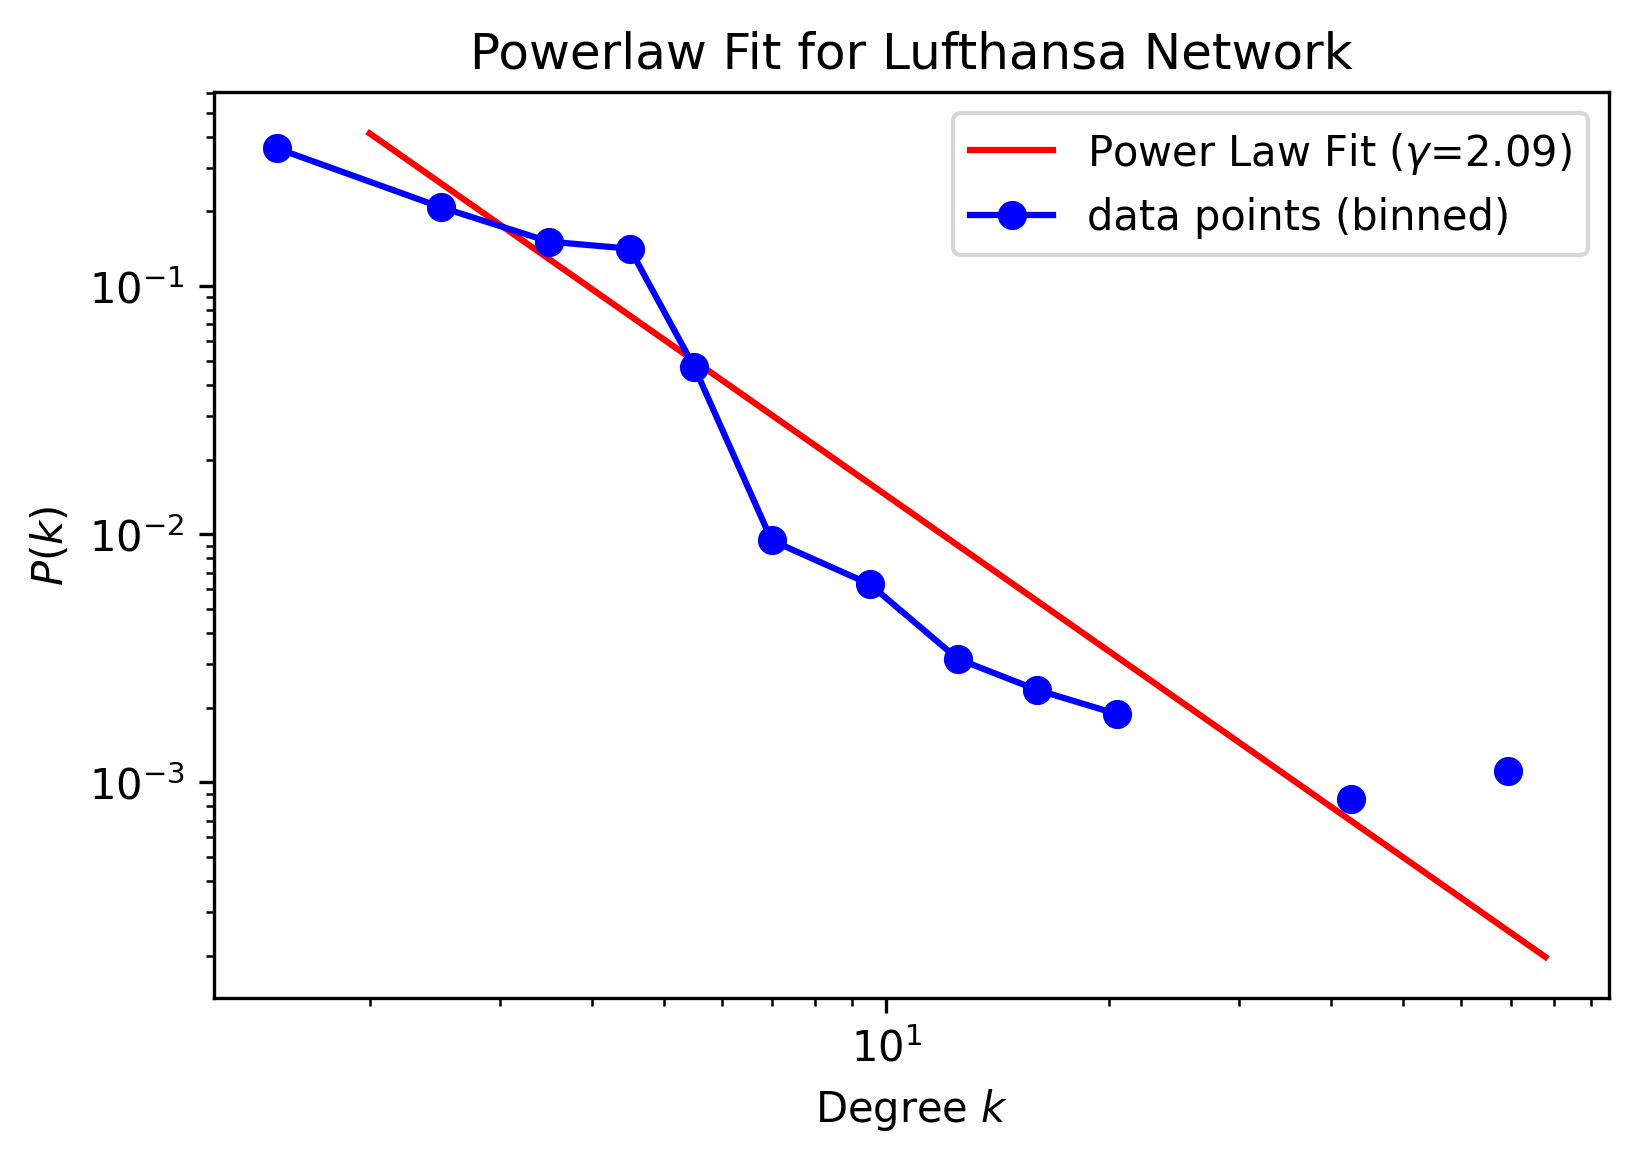



alpha (gamma in slides) := 2.0861353856248237
sigma (error) := 0.13171326231329758


In [56]:
GG = layer['Lufthansa']
GG_degree_dict = dict(GG.degree)
G_DEGS = [ GG_degree_dict[i] for i in GG.nodes() ]
# array with the degrees, sorted by node number
G_DEGS_NO_ZERO = [x for x in G_DEGS if x > 0]

fit = powerlaw.Fit(G_DEGS, discrete=True)
alpha = fit.power_law.alpha
sigma = fit.power_law.sigma

xx = np.arange(min(G_DEGS),max(G_DEGS))

fig, ax = plt.subplots(dpi=300)
plt.xlabel("Degree $k$")
plt.ylabel("$P(k)$")
fit.power_law.plot_pdf(color='r', ax=ax, label=f'Power Law Fit ($\gamma$={alpha:.2f})')
powerlaw.plot_pdf(G_DEGS_NO_ZERO, color="b", marker="o", label="data points (binned)")
plt.legend()
plt.savefig(f'SF_powerlaw_fit.pdf', dpi=600)
plt.title("Powerlaw Fit for Lufthansa Network")
plt.show()

print("\n\nalpha (gamma in slides) :=", alpha)
print("sigma (error) :=", sigma)


## BA Null Model
###  Compare degree distirution of airtraffic with BA null model
#### Construct undirect BA

In [ ]:
# define parameters, N, m
N = GG.number_of_nodes()
# m := avg degree
m = int(nx.number_of_edges(GG) / float(GG.number_of_nodes()))

In [ ]:
G_BA = nx.barabasi_albert_graph(N, m)

# add nodes
for node in GG.nodes:
    G_BA.add_node(node)

# add edges
g_degrees = nx.degree(G_BA)
g_degrees_dict = dict(g_degrees)
for edge in G_BA.edges:
  node_a = edge[0]
  node_b = edge[1]
  G_BA.add_edge(node_a, node_b)


In [ ]:
# calculate BA graph metrics for plots
GG_BA_in_degree_dict = dict(G_BA.degree)
G_BA_DEGS = [ GG_BA_in_degree_dict[i] for i in G_BA.nodes() ]
# for regular degrees
# G_BA_DEGS = [ G_BA.degree()[i] for i in G_BA.nodes() ]
G_BA_degree_counts = Counter(G_BA_DEGS)

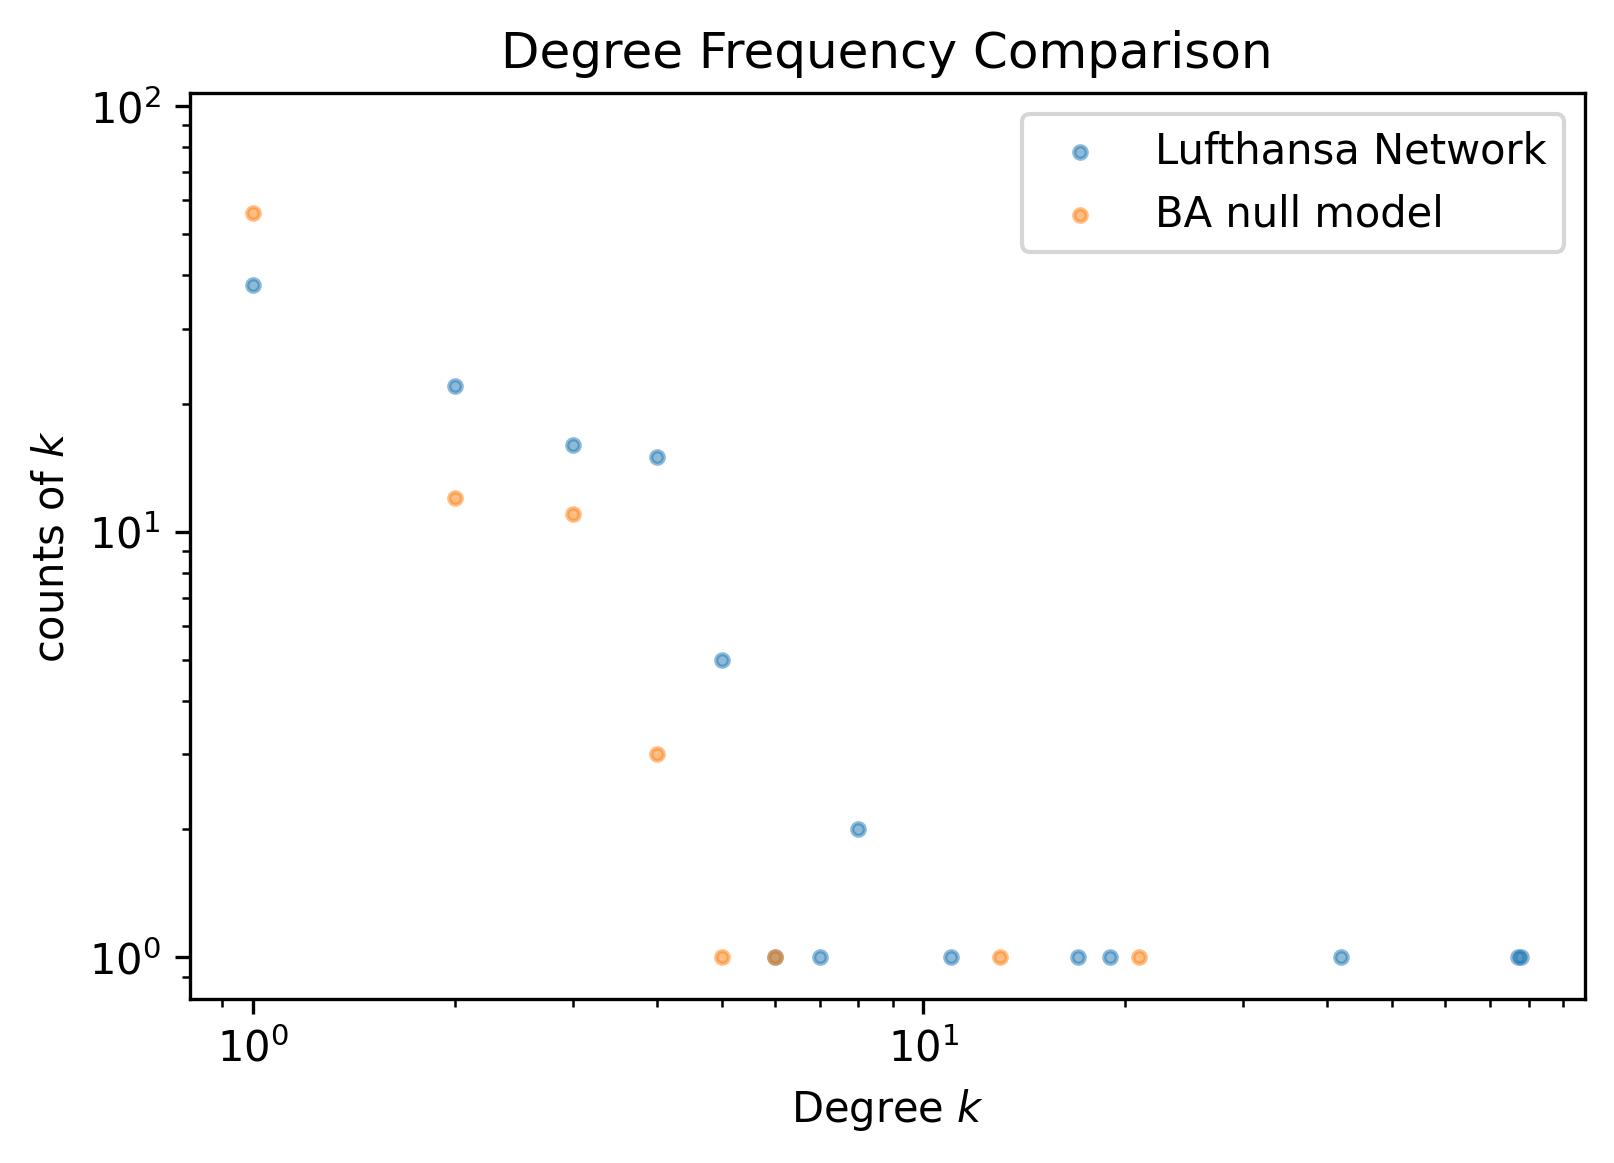

In [57]:
degree_counts = Counter(G_DEGS)
x, y = zip(*degree_counts.items())
x_BA, y_BA = zip(*G_BA_degree_counts.items())

fig3 = plt.figure(dpi=300)

# prep axes
plt.xlabel('Degree $k$')
plt.xscale('log')

plt.ylabel('counts of $k$')
plt.yscale('log')

plt.scatter(x, y, marker='.', label='Lufthansa Network', alpha=0.5)
plt.scatter(x_BA, y_BA, marker='.', label='BA null model', alpha=0.5)
plt.legend()
plt.savefig(f'degree_frequency_comparison.pdf', dpi=600)
plt.title('Degree Frequency Comparison')                                                                                                                                 # do plot
plt.show()

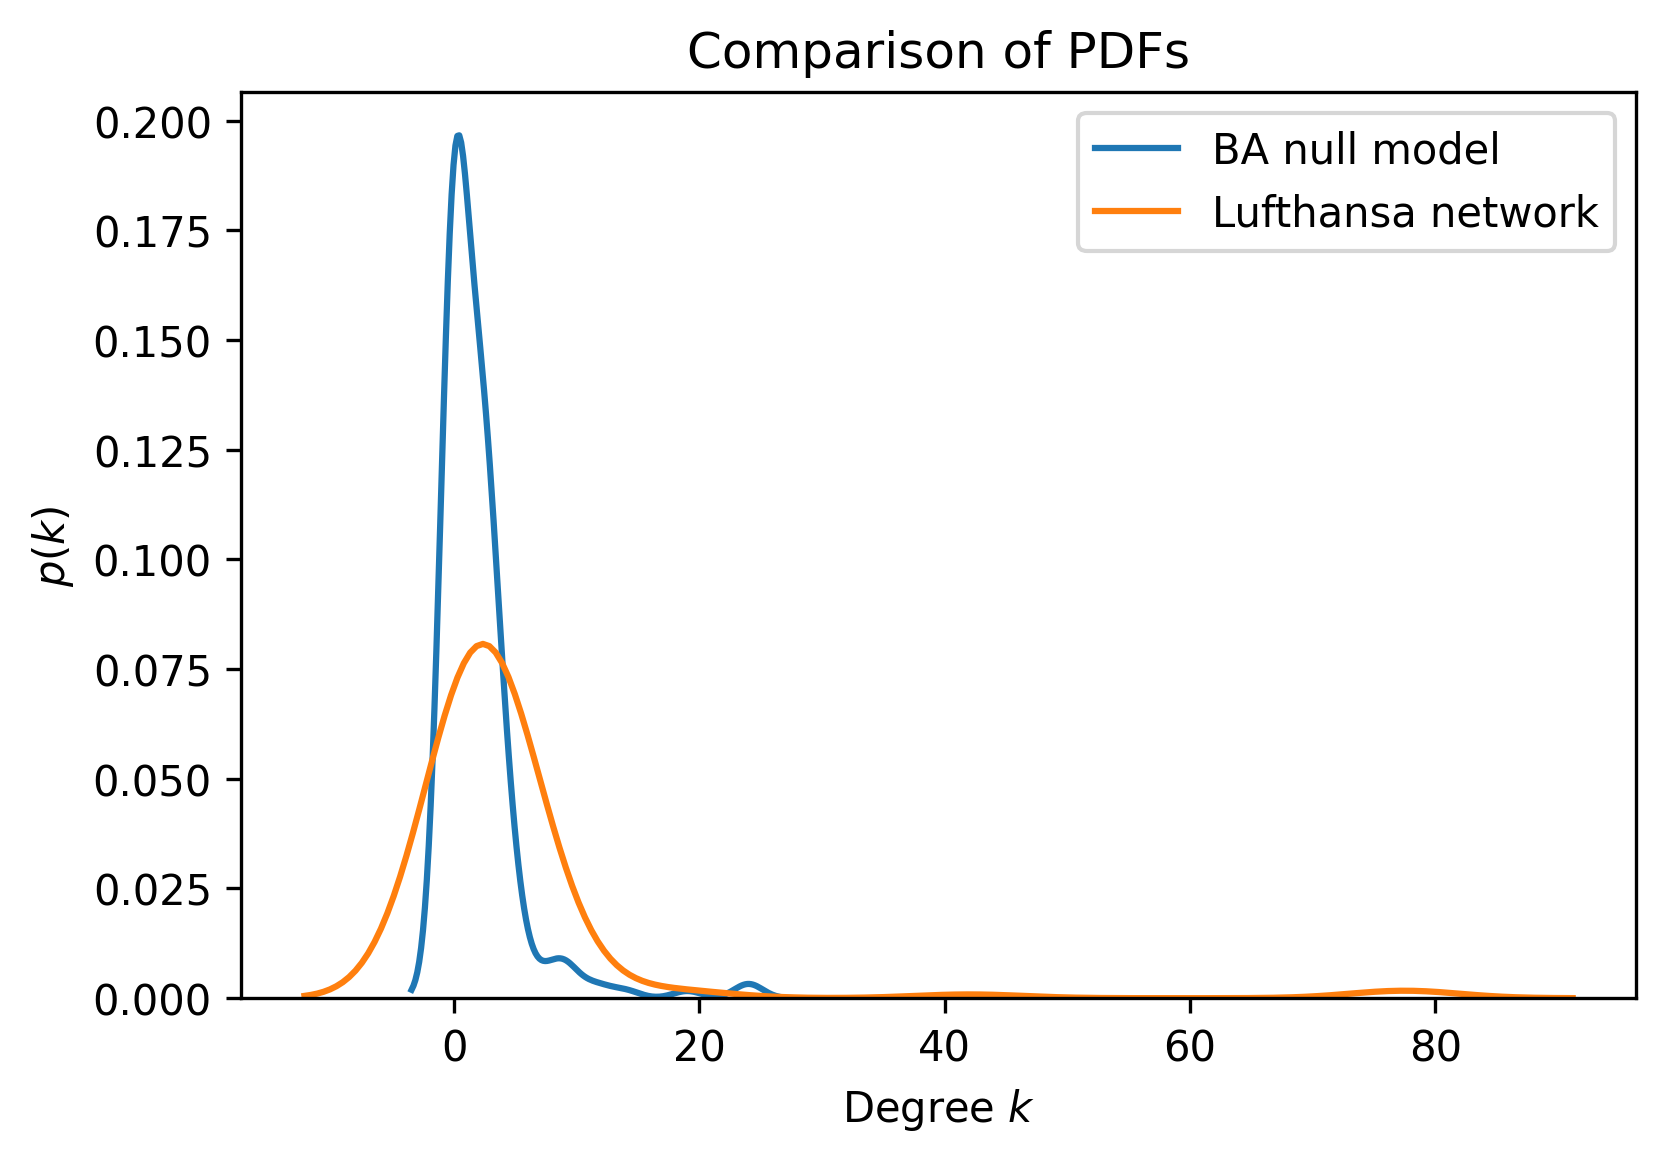

In [ ]:
#NOTE: if we want to use the pdfs, we have to do them as histograms, because
# we go into the negative degrees with the kde smoothing!

fig4 = plt.figure(dpi=300)
ax = sns.kdeplot(G_BA_DEGS, label="BA null model")
ax = sns.kdeplot(G_DEGS, ax=ax, label="Lufthansa network")
plt.legend()
plt.ylabel("$p(k)$")
plt.xlabel("Degree $k$")
plt.savefig(f'pdf_comparison.pdf', dpi=600)
plt.title("Comparison of PDFs")
plt.show()

### Interpretation

<b>Power Law Fit</b>: The power-law fit is sufficiently close, so it the model quite good (sigma of approx. 0.13).

<b>Degree counts</b>: The null model we built using Barabasi-Albert as basis shows data that is similar to what we observe in our air traffic network. Because
we know that the BA model produces scale-free networks, we can thus deduce that Lufthansa air traffic network is scale-free as well.

<b>Degree PDF comparison</b>: similarly, the comparison of the PDFs shows that the null model has a slightly narrower
(and consequently higher) curve than Lufthansa air traffic network, but the location of the distribution as well as the
overall characteristics in terms of shape are definitively comparable, further hinting at the fact that the air-traffic
network is scale-free.